## DoorDash Take-home Task
**Candidate**: Andrés Crucetta Nieto

####**Task Description**

Concretely, for a given delivery you must predict the total delivery duration seconds, i.e., the time from
- Start: the time consumer submits the order (`created_at`) to
- End: when the order will be delivered to the consumer (`actual_delivery_time`).

####**Objectives**
1. A high-level business summary explaining the key results to semi-technical readers. Include some feature interpretation and highlight the model’s performance relative to what is likely feasible.
2. A list of 3-5 features you believe would improve model performance if included in the training set.
   1. Please clearly articulate the value you believe adding these features would drive for the business.
3. Assume the model you designed would replace a model already in production. How would you assess your model’s performance relative to that of its predecessor before replacing the previous model?


####**Data**
- historical_data.csv: table of historical deliveries (your training set)
- data_to_predict.csv: data for deliveries that you must predict (label-free test set we will use for evaluation)
- data_description.txt: description of all columns in historical_data.csv and details of data_to_predict.csv


## Data Ingestion

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Import the linear models from scikit-learn
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [79]:
df = pd.read_csv('historical_data.csv')

## Data Cleaning & Preparation

**Time features**
- market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
- created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
- actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

**Store features**
- store_id: an id representing the restaurant the order was submitted for

**Order features**
- subtotal: total value of the order submitted (in cents)

**Market features**

DoorDash being a marketplace, we have information on the state of the marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of `created_at` (order submission time)
- total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
- total_busy_dashers: Subset of above `total_onshift_dashers` who are currently working on an order
- total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

### Removing NA values

In [80]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179759 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     179759 non-null  float64
 1   created_at                                    179759 non-null  object 
 2   actual_delivery_time                          179759 non-null  object 
 3   store_id                                      179759 non-null  int64  
 4   subtotal                                      179759 non-null  int64  
 5   total_onshift_dashers                         179759 non-null  float64
 6   total_busy_dashers                            179759 non-null  float64
 7   total_outstanding_orders                      179759 non-null  float64
 8   estimated_store_to_consumer_driving_duration  179759 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

### Creating delivery time variable

In [81]:
# Convert created_at and actual_delivery_time to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['order_fulfillment_time'] = df['actual_delivery_time']-df['created_at']

In [82]:
# Convert datetime variable to minutes
df['order_fulfillment_time_min'] = df['order_fulfillment_time'].dt.total_seconds().div(60).astype(int)

### Removing outliers

In [83]:
# Removing outliers in order_fulfillment_time_min from dataset using zscore
# For each column, it first computes the Z-score of each value in the column, 
# relative to the column mean and standard deviation.
df = df[(np.abs(stats.zscore(df['order_fulfillment_time_min'])) < 3)]

In [84]:
# Removing outliers in subtotal from dataset using zscore
df = df[(np.abs(stats.zscore(df['subtotal'])) < 3)]

In [85]:
# Removing outliers in estimated_store_to_consumer_driving_duration from dataset using zscore
df = df[(np.abs(stats.zscore(df['estimated_store_to_consumer_driving_duration'])) < 3)]

## Feature Creation

#### Creating the following features
- Day of the week 
- Time of the day
- Range of Subtotals
- Range of delivery times

In [86]:
# Monday = 0, Sunday = 6
df['weekday'] = df['created_at'].dt.dayofweek

In [87]:
# In 24:00 format (0:01 AM to 11:59 PM)
df['hour_of_creation'] = df['created_at'].dt.hour

In [88]:
# Converting subtotals to dollars
df['subtotal'] = df['subtotal'].div(100)

# Creating range of subtotals
df['subtotal_quartile'] = pd.qcut(df['subtotal'], q=4)

df.subtotal_quartile.value_counts()

(-0.001, 14.0]    44411
(33.2, 81.81]     43866
(21.97, 33.2]     43861
(14.0, 21.97]     43336
Name: subtotal_quartile, dtype: int64

In [89]:
# Creating discrete range of hours
df['timeofday_bin'] = pd.cut(df['hour_of_creation'],bins=[-0.001,4,19,24],precision=0,labels=["Early AM (0-4 AM)","Middle_Day (4AM-7PM)","Dinner (7PM-12PM)"])
df['timeofday_bin'].value_counts()

Early AM (0-4 AM)       106451
Dinner (7PM-12PM)        39659
Middle_Day (4AM-7PM)     29364
Name: timeofday_bin, dtype: int64

## Data Exploration

 Observing general distribution of values

In [90]:
df.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,order_fulfillment_time,order_fulfillment_time_min,weekday,hour_of_creation
count,175474.000000,175474.000000,175474.000000,175474.000000,175474.000000,175474.000000,175474.000000,175474,175474.000000,175474.000000,175474.000000
mean,2.750145,3547.738827,25.552451,44.745985,41.685817,57.911890,544.376238,0 days 00:46:58.317574113,46.479923,3.228171,8.509642
std,1.331406,2058.670817,15.120443,34.547608,32.161995,52.643568,217.039325,0 days 00:17:06.320338826,17.107535,2.042753,8.684354
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0 days 00:01:41,1.000000,0.000000,0.000000
25%,2.000000,1686.000000,14.000000,17.000000,15.000000,17.000000,383.000000,0 days 00:34:53,34.000000,1.000000,2.000000
50%,2.000000,3614.000000,21.970000,36.000000,34.000000,41.000000,543.000000,0 days 00:44:01,44.000000,3.000000,3.000000
75%,4.000000,5331.000000,33.200000,65.000000,62.000000,85.000000,701.000000,0 days 00:55:47,55.000000,5.000000,19.000000
max,6.000000,6987.000000,81.810000,171.000000,154.000000,285.000000,1199.000000,0 days 02:09:50,129.000000,6.000000,23.000000


Delivery time by hour of creation

In [91]:
df.groupby(by="timeofday_bin")[['order_fulfillment_time_min','weekday','total_onshift_dashers','subtotal']].mean()

,order_fulfillment_time_min,weekday,total_onshift_dashers,subtotal
timeofday_bin,,,,
Early AM (0-4 AM),49.317761,3.190416,56.767330,28.329707
Middle_Day (4AM-7PM),42.697623,3.299346,21.921366,21.270713
Dinner (7PM-12PM),41.663179,3.276810,29.378426,21.268107


Delivery time by day of the week and time of the dat

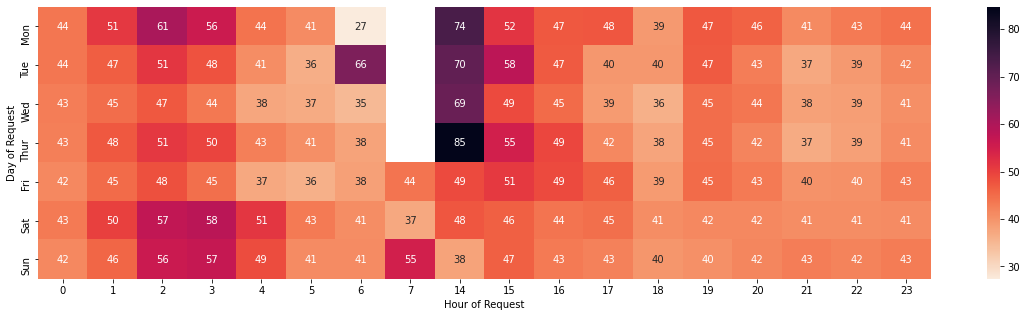

In [92]:
df_pivot = df.pivot_table(index="weekday", columns="hour_of_creation",values="order_fulfillment_time_min", aggfunc="mean")
weekdays = ["Mon",'Tue','Wed','Thur','Fri','Sat','Sun']
df_pivot = df_pivot.rename(index={0:"Mon",1:'Tue',2:"Wed",3:"Thur",4:"Fri",5:"Sat",6:"Sun"})

fig_dims = (20,5)
fig, ax = plt.subplots(figsize=fig_dims)

cmap = sns.cm.rocket_r
hmap = sns.heatmap(df_pivot, annot=True, ax=ax,cmap=cmap) 
hmap.set(xlabel="Hour of Request",ylabel="Day of Request")

plt.show()

Delivery times by estimated_store_to_consumer_driving_duration

## Feature Selection

### Creating dummy variables out of categorical variables

In [93]:
df = pd.get_dummies(df, columns=['weekday','subtotal_quartile', 'timeofday_bin','market_id'])

### Exploring correlation among features

In [101]:
df.columns

Index(['created_at', 'actual_delivery_time', 'store_id', 'subtotal',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'order_fulfillment_time', 'order_fulfillment_time_min',
       'hour_of_creation', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6',
       'subtotal_quartile_(-0.001, 14.0]', 'subtotal_quartile_(14.0, 21.97]',
       'subtotal_quartile_(21.97, 33.2]', 'subtotal_quartile_(33.2, 81.81]',
       'timeofday_bin_Early AM (0-4 AM)', 'timeofday_bin_Middle_Day (4AM-7PM)',
       'timeofday_bin_Dinner (7PM-12PM)', 'market_id_1.0', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0'],
      dtype='object')

In [121]:
# Dropping columns unused
df_reduced = df.drop(columns=['created_at','actual_delivery_time','store_id','subtotal','order_fulfillment_time','hour_of_creation'])

In [122]:
features = df_reduced.drop(columns=['order_fulfillment_time_min'])
labels = df_reduced['order_fulfillment_time_min']

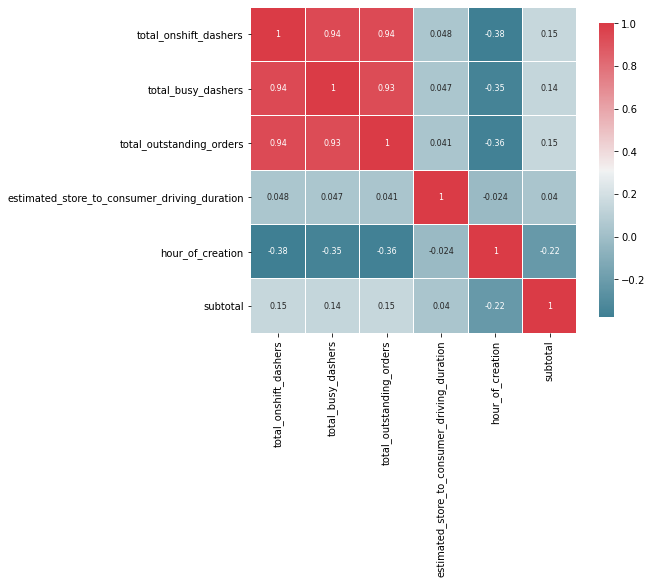

In [123]:
cols_df = ['total_onshift_dashers','total_busy_dashers','total_outstanding_orders',
      'estimated_store_to_consumer_driving_duration','hour_of_creation',
      'subtotal']
corr_df = df[cols_df]

#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(8, 6))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(df.corr(),
                    cmap = colormap, square=True, cbar_kws={'shrink':.9 }, ax=ax,
                    annot=True,
                    linewidths=0.1,vmax=1.0, linecolor='white', 
                    annot_kws={'fontsize':8 }
    )
    plt.show()
    # plt.title('Pearson Correlation of Features', y=1.05, size=15,ax=ax) 
    return 
correlation_heatmap(corr_df)

### Dropping features with a correlation higher than 0.9

In [115]:
# Create correlation matrix
corr_matrix = corr_df.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop_m = [column for column in upper.columns if any(abs(upper[column]) > 0.90)]

# Drop features 
df_m = df.drop(to_drop_m, axis=1)
features_m = features.drop(to_drop_m, axis=1)

In [118]:
features_m.corr()

,total_onshift_dashers,estimated_store_to_consumer_driving_duration,hour_of_creation,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,...,"subtotal_quartile_(33.2, 81.81]",timeofday_bin_Early AM (0-4 AM),timeofday_bin_Middle_Day (4AM-7PM),timeofday_bin_Dinner (7PM-12PM),market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
total_onshift_dashers,1.000000,0.048068,-0.375381,-0.030639,-0.081233,-0.051712,-0.010529,0.044300,0.096418,0.014516,...,0.118829,0.432130,-0.296179,-0.240373,-0.305140,0.341839,-0.278321,0.268120,-0.201635,0.000403
estimated_store_to_consumer_driving_duration,0.048068,1.000000,-0.023786,-0.001816,-0.007151,-0.004794,-0.000344,0.000767,0.003571,0.008056,...,0.030870,0.026085,-0.023010,-0.009930,-0.064681,0.063664,-0.012621,0.002301,-0.000223,0.001998
hour_of_creation,-0.375381,-0.023786,1.000000,-0.020563,-0.000518,0.008230,0.000514,0.009033,-0.012891,0.016239,...,-0.173817,-0.927655,0.327606,0.791076,0.005054,0.004413,0.013821,-0.024900,0.008409,-0.002992
weekday_0,-0.030639,-0.001816,-0.020563,1.000000,-0.148473,-0.149410,-0.152887,-0.162239,-0.183984,-0.180530,...,0.007654,0.019835,-0.014463,-0.010259,-0.000865,-0.000579,0.003345,-0.004187,0.004075,0.002367
weekday_1,-0.081233,-0.007151,-0.000518,-0.148473,1.000000,-0.139995,-0.143252,-0.152015,-0.172390,-0.169153,...,-0.022678,0.004686,-0.001218,-0.004386,0.002406,-0.005069,0.007125,-0.002906,0.000579,0.002300
weekday_2,-0.051712,-0.004794,0.008230,-0.149410,-0.139995,1.000000,-0.144157,-0.152975,-0.173479,-0.170221,...,-0.023070,-0.002832,-0.001854,0.004962,0.008720,-0.006389,-0.005068,0.004753,-0.003568,0.000602
weekday_3,-0.010529,-0.000344,0.000514,-0.152887,-0.143252,-0.144157,1.000000,-0.156535,-0.177515,-0.174182,...,-0.018243,0.006233,-0.006053,-0.001878,-0.000497,-0.004382,-0.004218,0.009901,-0.002104,-0.002019
weekday_4,0.044300,0.000767,0.009033,-0.162239,-0.152015,-0.152975,-0.156535,1.000000,-0.188374,-0.184837,...,-0.015539,-0.009973,0.011494,0.001389,0.003272,-0.002365,-0.002919,0.003028,-0.001679,-0.001901
weekday_5,0.096418,0.003571,-0.012891,-0.183984,-0.172390,-0.173479,-0.177515,-0.188374,1.000000,-0.209611,...,0.035515,0.007243,0.001016,-0.009366,-0.005670,0.007444,-0.003624,-0.000666,0.001631,-0.002354
weekday_6,0.014516,0.008056,0.016239,-0.180530,-0.169153,-0.170221,-0.174182,-0.184837,-0.209611,1.000000,...,0.027639,-0.023336,0.009571,0.018713,-0.005788,0.009089,0.005309,-0.008752,0.000676,0.001256


## Modeling

In [98]:
# --- Grid Search --- # 
def grid_search(X_train, X_test, y_train, y_test, models, parameters, time, measure, feat_set):
    """
    Looks for the best model based off a list of models and their parameters
    """    
    # Begin timer 
    start = datetime.datetime.now()

    # Initialize results data frame 
    results = []

    # Loop over models 
    for model_key in models.keys(): 

        # Loop over parameters 
        for params in parameters[model_key]: 
            print("Training model:", model_key, "|", params)
            
            # Create model 
            model = models[model_key]
            model.set_params(**params)
            #print("Model:", model)
            
            # Normalize Features
            new_model = Pipeline([('scaler', StandardScaler()), ('model', model)])

            # Fit model on training set 
            new_model.fit(X_train, y_train.values.ravel())
            
            # Predict on testing set 
            y_hat = new_model.predict(X_test)
            
            # Evaluate predictions 
            mse_acc = metrics.accuracy_score(y_test, y_hat)
            mse_prec = metrics.precision_score(y_test, y_hat)
            mse_recall = metrics.recall_score(y_test, y_hat)
            mse_f1 = metrics.f1_score(y_test, y_hat)
            
            # Store results in your results data frame 
            result = [time, measure, feat_set, model_key,params,mse_acc,mse_prec,mse_recall,mse_f1]
            #print(result)
            results.append(result)
            
    # End timer
    stop = datetime.datetime.now()
    print("Time Elapsed:", stop - start) 
    return results
       

In [99]:
# Config: Dictionaries of models and hyperparameters
models = {
    'LogisticRegression': LogisticRegression(), 
    'LinearSVC': LinearSVC(), 
    'KNeighbors': KNeighborsClassifier(), 
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
}

grid = {
    'LogisticRegression': [{'penalty': x, 'C': y, 'random_state': 0, 'max_iter': 5000} 
                           for x in ('l2', 'none') \
                           for y in (0.01, 0.1, 1, 10, 100)],
    'LinearSVC': [{'C': x, 'random_state': 0, 'dual': False} \
                  for x in (0.01, 0.1, 1, 10, 100)],
    'KNeighbors': [{'n_neighbors':x, "weights":y, "metric":z} \
                   for x in (3,5,11,19) \
                   for y in ('uniform','distance') \
                   for z in ('euclidean','manhattan')], 
    'DecisionTree': [{'criterion':x, "max_depth":y, "min_samples_split":z} \
                   for x in ('gini', 'entropy') \
                   for y in (1,3,5) \
                   for z in (2,5,10)],
    'RandomForest': [{'criterion':x, "max_depth":y, "min_samples_split":z, "n_estimators":a} \
                   for x in ('gini', 'entropy') \
                   for y in (1,3,5) \
                   for z in (2,5,10) \
                   for a in (100,1000,5000)]
}

full_results = pd.DataFrame(columns=['Outcome Timeframe', 
                                     'Outcome Benchmark',
                                     'Feature Set',
                                     'Model',
                                     'Parameters', 
                                     'Accuracy',
                                     'Precision',
                                     'Recall',
                                     'F1 Score'])

#run grid search on each outcome and feature set
for time in ["1Y", "5Y"]:
    for feat_set, features in feature_sets.items() :
      var = "Gentrified " + time + " Median"
      X_train, X_test, y_train, y_test = train_test_split(smotes[var][feat_set]["X"], 
                                                          smotes[var][feat_set]["y"], 
                                                          test_size=0.2,
                                                          random_state=0)
      results = grid_search(X_train, X_test, y_train, y_test, 
                            models, grid, time, "Median", feat_set)
      results_df = pd.DataFrame(results, columns=['Outcome Timeframe', 
                                    'Outcome Benchmark',
                                    'Feature Set',
                                    'Model',
                                    'Parameters', 
                                    'Accuracy',
                                    'Precision',
                                    'Recall',
                                    'F1 Score'])
      full_results = full_results.append(results_df)

NameError: name 'LogisticRegression' is not defined

## Evaluation